In [121]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from fluxsus.DBFIX import DBFIX
from fluxsus.fluxnets.fluxnets import CityFlux, CityHospitalFlux
from fluxsus.utils_ import f_infomap
from scipy.stats import linregress

In [40]:
# -- Open the three main datasets: CNES, CE GEODATA, SIHSUS.
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
sihpath = os.path.join(basepath, "opendatasus", "sihsus", "PARQUET")
geopath = os.path.join(basepath, "shapefilesceqgis")
gml_folder = os.path.join(basepath, "redes_aih")

In [80]:
pop_df = pd.read_excel(os.path.join(geopath, "POP. MUNICIPIO CEARA_ 2009_2023.xlsx"), header=4)[1:-3]
pop_df.columns = ['GEOCOD6','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022', '2022.1']
pop_df["GEOCOD6"] = pop_df["GEOCOD6"].apply(lambda x: x.split(" ")[0])
pop_df["2018-2022(MEAN)"] = pop_df[['2018', '2019','2020','2021','2022']].apply(lambda x: np.mean(x.values), axis=1)
pop_df.head()

,GEOCOD6,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2022.1,2018-2022(MEAN)
1,230010,10483.0,10668.0,10790.0,10908.0,11023.0,11137.0,11259.0,11380.0,11498.0,11619.0,11737.0,11853.0,11965.0,10038.0,10038.0,11442.4
2,230015,13766.0,13938.0,14050.0,14162.0,14266.0,14372.0,14486.0,14598.0,14707.0,14820.0,14929.0,15036.0,15140.0,14027.0,14027.0,14790.4
3,230020,57606.0,58349.0,58837.0,59313.0,59773.0,60230.0,60722.0,61208.0,61679.0,62165.0,62641.0,63104.0,63556.0,64806.0,64806.0,63254.4
4,230030,51971.0,52311.0,52532.0,52750.0,52961.0,53169.0,53393.0,53616.0,53830.0,54052.0,54270.0,54481.0,54687.0,44962.0,44962.0,52490.4
5,230040,16382.0,16532.0,16631.0,16727.0,16820.0,16912.0,17012.0,17110.0,17205.0,17303.0,17399.0,17493.0,17584.0,14076.0,14076.0,16771.0


In [81]:
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
geodata_df = geodata_df.merge(pop_df[["GEOCOD6", "2018-2022(MEAN)"]], on="GEOCOD6", how="left")


In [97]:
fname = "CITYFLUX_2018_2022_ALL.gml"
graph = nx.read_gml(os.path.join(gml_folder, "novo", fname))

# -- aggregate incoming information
for u in graph.nodes():
    in_edges = [ e for e in graph.in_edges(u) ]
    graph.nodes[u]['incoming_people'] = 0
    graph.nodes[u]['incoming_cost'] = 0
    for e in in_edges:
        graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
        graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

module_count = f_infomap(graph, weight_col='admission_count')
module_cost = f_infomap(graph, weight_col='total_cost')

# -- include new modularization
module_count_code, module_cost_code = {}, {}
module_count_n, module_cost_n = {}, {}
for u in graph.nodes():
    module_count_code.update({ graph.nodes[u]['municipio_code'] : module_count[int(u)] })
    module_cost_code.update({ graph.nodes[u]['municipio_code'] : module_cost[int(u)] })

    module_count_n.update({ graph.nodes[u]['municipio_code'] : graph.nodes[u]['incoming_people'] })
    module_cost_n.update({ graph.nodes[u]['municipio_code'] : graph.nodes[u]['incoming_cost'] })

for u in graph.nodes():
    graph.nodes[u]['infomap_count_module_id'] = module_count[int(u)]
    graph.nodes[u]['infomap_cost_module_id'] = module_cost[int(u)]

geodata_df["INFOMAP_COUNT_MODULE"] = geodata_df["GEOCOD6"].map(module_count_code)
geodata_df["INFOMAP_COST_MODULE"] = geodata_df["GEOCOD6"].map(module_cost_code)
geodata_df["INFLOW_PEOPLE"] = geodata_df["GEOCOD6"].map(module_count_n)
geodata_df["INFLOW_COST"] = geodata_df["GEOCOD6"].map(module_cost_n)

found 9 modules with codelength: 2.4984634636108685
found 3 modules with codelength: 2.479820621015808


In [98]:
geodata_df

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,2018-2022(MEAN),INFOMAP_COUNT_MODULE,INFOMAP_COST_MODULE,INFLOW_PEOPLE,INFLOW_COST
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),-39.037538,-7.359907,11442.4,9,3,0,0.00
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),-38.663052,-4.222417,14790.4,1,1,0,0.00
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),-40.089128,-2.967916,63254.4,3,1,9169,4289899.29
3,2300309,ACOPIARA,230030,5,18,"POLYGON ((-39.21390 -5.99175, -39.21278 -5.991...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4440719.425 -681940.298, -4440964.9...",POINT (-39.49282 -6.12241),-39.492823,-6.122411,52490.4,2,2,964,544820.91
4,2300408,AIUABA,230040,2,14,"POLYGON ((-40.14849 -6.36051, -40.14816 -6.360...",Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...","POLYGON ((-4448196.104 -680357.114, -4447996.7...",POINT (-40.29895 -6.60520),-40.298951,-6.605196,16771.0,1,1,48,21815.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2313807,URUBURETAMA,231380,1,6,"POLYGON ((-39.55089 -3.58253, -39.53197 -3.582...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4402776.237 -343001.709, -4402648.3...",POINT (-39.51578 -3.62282),-39.515783,-3.622815,21591.6,4,1,8,5122.01
180,2313906,URUOCA,231390,4,11,"POLYGON ((-40.70713 -3.23916, -40.70319 -3.240...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","MULTIPOLYGON (((-4518310.108 -507950.779, -451...",POINT (-40.68015 -3.32123),-40.680148,-3.321228,13850.4,3,1,11,4512.41
181,2313955,VARJOTA,231395,4,11,"POLYGON ((-40.55755 -4.20910, -40.55869 -4.208...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","MULTIPOLYGON (((-4518310.108 -507950.779, -451...",POINT (-40.49453 -4.16803),-40.494526,-4.168031,18376.8,3,1,92,40826.39
182,2314003,VÁRZEA ALEGRE,231400,5,17,"POLYGON ((-39.28999 -6.65783, -39.28999 -6.657...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4305065.442 -748330.453, -4305140.3...",POINT (-39.29801 -6.77220),-39.298008,-6.772197,40444.4,2,2,2817,1293256.37


In [45]:
for u in graph.nodes():
    if graph.nodes[u]['municipio_code']=="230010":
        print(u)
        print(graph.nodes[u])

0
{'municipio_code': '230010', 'municipio_name': 'ABAIARA', 'macro_id': 5, 'macro_name': 'Superintendência Regional de Saúde Cariri', 'cres_id': 19, 'lat': -7.35990681440754, 'lon': -39.03753839591732, 'infomap_count_module_id': 9, 'infomap_cost_module_id': 3}


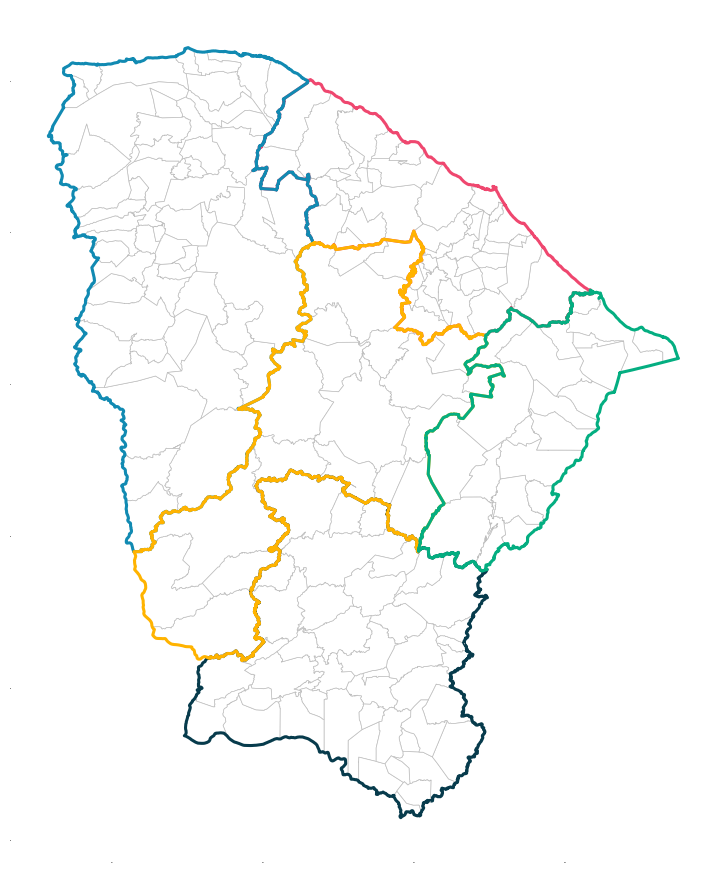

In [108]:
cmap_macro = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
geodata_df['MACRO_COLOR'] = geodata_df["MACRO_ID"].map(cmap_macro)
#macro_df['MACRO_COLOR'] = macro_df["ID"].map(cmap_macro)
#mun_df1.head()

# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
geodata_df.set_geometry('geometry_macro').drop_duplicates("MACRO_ID").plot(ax=ax1, color="none", edgecolor=geodata_df.drop_duplicates("MACRO_ID")["MACRO_COLOR"], linewidth=2.2)

#mun_df1.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
#macro_df.plot(ax=ax1, color="none", edgecolor=geodata_df["MACRO_COLOR"], linewidth=2.2)

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)

In [32]:
geodata_df.set_geometry('geometry_macro').drop_duplicates("MACRO_ID")

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,MACRO_COLOR
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),-39.037538,-7.359907,#073b4c
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),-38.663052,-4.222417,#ef476f
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),-40.089128,-2.967916,#118ab2
4,2300408,AIUABA,230040,2,14,"POLYGON ((-40.14849 -6.36051, -40.14816 -6.360...",Superintendência Regional de Saúde Sertão Central,"POLYGON ((-40.08511 -6.36860, -40.08445 -6.370...","POLYGON ((-4448196.104 -680357.114, -4447996.7...",POINT (-40.29895 -6.60520),-40.298951,-6.605196,#ffb300
7,2300705,ALTO SANTO,230070,3,10,"POLYGON ((-38.22391 -5.38999, -38.22076 -5.388...",Superintendência Regional de Saúde Litoral Leste,"POLYGON ((-37.77077 -4.42713, -37.76948 -4.426...","POLYGON ((-4247952.621 -660742.082, -4248308.9...",POINT (-38.20057 -5.51762),-38.200572,-5.517625,#04ae81


In [47]:
graph.degree('0')

12

In [48]:
graph.in_degree('0')

0

In [49]:
graph.out_degree('0')

12

In [95]:
for u in graph.nodes():
    in_edges = [ e for e in graph.in_edges(u) ]
    graph.nodes[u]['incoming_people'] = 0
    graph.nodes[u]['incoming_cost'] = 0
    for e in in_edges:
        graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
        graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

In [94]:
[n for n in graph.in_edges('4')][0]

('3', '4')

In [111]:
def power_law_f(x, prefactor, power):
    return prefactor*(x**power)

exponent: 2.4672204367017696, prefactor: -9.004516053121526


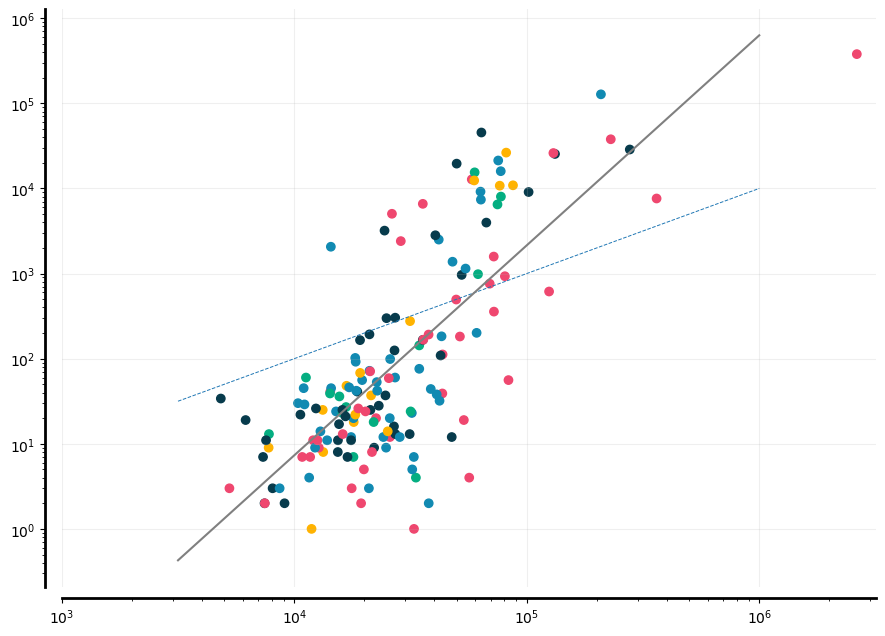

In [141]:
# -- fit
xdata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["INFLOW_PEOPLE"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")


figs, axs = plt.subplots(1, figsize=(10.5,7.5))

axs.grid(alpha=0.2, zorder=0)
# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs.spines[i].set_linewidth(2)

axs.spines['top'].set_linewidth(0)
axs.spines['right'].set_linewidth(0)
axs.spines['bottom'].set_position(('outward', 8))
axs.spines['left'].set_position(('outward', 12))

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**-2, 1)
axs.plot(x, y, ls="--", lw=0.7)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs.plot(x, y_fit, ls="-", color="gray", lw=1.5)

axs.set_xlim([10**3, 10**6.5])

# points
axs.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_PEOPLE"], color=geodata_df["MACRO_COLOR"])
axs.set_xscale('log')
axs.set_yscale('log')

exponent: 2.716824101794341, prefactor: -7.386871179063773


(1000, 3162277.6601683795)

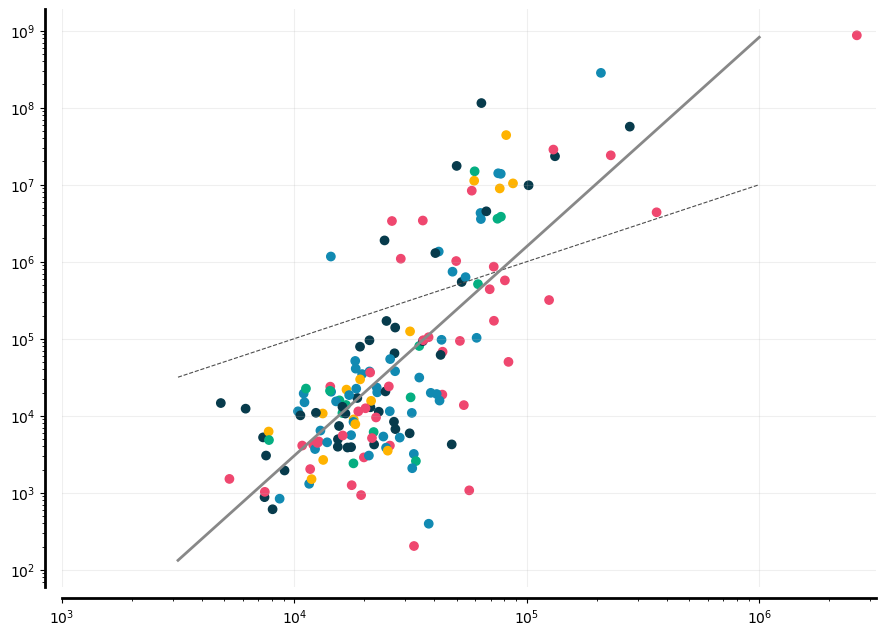

In [147]:
# -- fit
xdata = geodata_df[geodata_df["INFLOW_COST"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_COST"]!=0]["INFLOW_COST"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")

figs1, axs1 = plt.subplots(1, figsize=(10.5,7.5))

axs1.grid(alpha=0.2, zorder=0)

# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs1.spines[i].set_linewidth(2)

axs1.spines['top'].set_linewidth(0)
axs1.spines['right'].set_linewidth(0)
axs1.spines['bottom'].set_position(('outward', 8))
axs1.spines['left'].set_position(('outward', 12))

axs1.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["INFLOW_COST"], color=geodata_df["MACRO_COLOR"])
axs1.set_xscale('log')
axs1.set_yscale('log')

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**1, 1)
axs1.plot(x, y, ls="--", color="#4d4d4d", lw=0.8)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs1.plot(x, y_fit, ls="-", color="#888888", lw=2.0)

axs1.set_xlim([10**3, 10**6.5])

In [128]:
xdata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["INFLOW_PEOPLE"]!=0]["INFLOW_PEOPLE"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))

In [132]:
res_

LinregressResult(slope=2.4672204367017696, intercept=-9.004516053121526, rvalue=0.7594366999050762, pvalue=4.065949024885814e-31, stderr=0.16868173394823432, intercept_stderr=0.7515347806136695)